In [1]:

import os
import pandas as pd
import numpy as np

from glob import glob

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
# matched_up_dir='/glade/campaign/acom/acom-da/SERVIR/match_aeronet_viirs/matched_DT_6hours_TW/' #finding pairs in MATCH_TIME_WINDOW = 6.0; 
stat_ret='DT' #analysis on dark target and then used the plot name
stat_ret='DB' #analysis on dark target and then used the plot name
matched_up_dir='/glade/campaign/acom/acom-da/SERVIR/match_aeronet_viirs/matched_{}_1hours_TW/'.format(stat_ret) #finding pairs in MATCH_TIME_WINDOW = 1.0; 

name_tag=matched_up_dir.split('/')[-2]#name tag for the matched files, for instance matched_6hours_TW
plots_dir='/glade/campaign/acom/acom-da/SERVIR/match_aeronet_viirs/plots/'


#
/****** Matching  parameters used ******/
# 
NVLDAER = 2;  /* minimum number of valid AERONET measurements used for averaging */
# 
MATCH_TIME_WINDOW = 1.0;  /* AERONET matching time window in hour (centered on satellite overpass time) */ 
# 
MATCH_RADIUS = 27.5;      /* Satellite retrievals matching spatial domain (radius [km] of circle centered on station)  */ 
# 
MIN_N_MATCH_PIX = 2;      /* Minimum number of pixels within matching domain */


Functions

In [25]:

def optimize_regression_fit_np(x, y, state='aod2aod', max_iterations=100, tolerance=0.01):
    """
    Fit a linear regression using np.polyfit and optimize the fit to ensure at least one standard deviation
    of the data fits within the regression line.

    Parameters:
    - x=df[x_col] the input of regression 
    - y=df[y_col] the output of regression 
    - max_iterations (int): Maximum number of iterations for optimization.
    - tolerance (float): Tolerance for stopping the optimization.
    

    Returns:
    - slope (float): Optimized slope of the regression line.
    - intercept (float): Optimized intercept of the regression line.
    - std_within_fit (float): Standard deviation of points within the fit.
    """


    # Initial fit using np.polyfit
    slope, intercept = np.polyfit(x, y, 1)
    # Optimization loop
    for iteration in range(max_iterations):
        # # Identify points within one standard deviation
        # within_std = np.abs(residuals) <= std
    # Calculate initial upper and lower bounds
        if state=='aod2aod':
            upper_bound = x+(slope * x + intercept)
            lower_bound = x-(slope * x + intercept)
        # elif state=='error2aod':
        #     print('error2aod')

        #     # slope and intercept of equeation are basically for standard deviation of errors
        #     upper_bound=slope_error * x + intercept_error+slope * x + intercept
        #     lower_bound=slope_error * x + intercept_error-slope * x - intercept

        # Check how many points lie within the bounds
        within_bounds = (y >= lower_bound) & (y <= upper_bound)
        percentage_within_bounds = np.sum(within_bounds) / len(y)
        # Print progress
        print(f"Iteration {iteration + 1}: {percentage_within_bounds:.2%} of points within bounds.")
        # If 68% of the points are within bounds, stop optimization
        if percentage_within_bounds >= 0.68:
            print(f"Optimization converged after {iteration + 1} iterations.")
            break

        # Adjust slope and intercept to improve fit
        adjustment_factor = tolerance * (1 - percentage_within_bounds)
        slope += adjustment_factor * np.sign(np.mean(y - (slope * x + intercept)))
        intercept += adjustment_factor * np.sign(np.mean(y - (slope * x + intercept)))

    return slope, intercept, percentage_within_bounds

In [26]:
def optimize_regression_fit_np_error_2aod(df, x_col, y_col, max_iterations=100, tolerance=0.01):
  
    """
    Fit two linear regressions (mean and standard deviation) on binned data and optimize the fit to ensure
    at least 68% of the data lies within the combined bounds.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - x_col (str): Column name for the x-axis (independent variable).
    - y_col (str): Column name for the y-axis (dependent variable).
    - max_iterations (int): Maximum number of iterations for optimization.
    - tolerance (float): Adjustment factor for slopes and intercepts during optimization.

    Returns:
    - slope_mean (float): Optimized slope of the mean regression line.
    - intercept_mean (float): Optimized intercept of the mean regression line.
    - slope_std (float): Optimized slope of the standard deviation regression line.
    - intercept_std (float): Optimized intercept of the standard deviation regression line.
    - percentage_within_bounds (float): Final percentage of points within the bounds.
    """
    # Bin the data into intervals of 0.1 along the x-axis
    bins = np.arange(df[x_col].min(), df[x_col].max() + 0.1, 0.1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    means = []
    stds = []

    # Calculate mean and standard deviation for each bin
    for i in range(len(bins) - 1):
        bin_data = df[(df[x_col] >= bins[i]) & (df[x_col] < bins[i + 1])]
        means.append(bin_data[y_col].mean())
        stds.append(bin_data[y_col].std())

    # Remove NaN values from means
    means = np.array(means)
    stds = np.array(stds)
    bin_centers = bin_centers[~np.isnan(means)]
    means = means[~np.isnan(means)]
    

    # Initial fits for mean and standard deviation
    slope_mean, intercept_mean = np.polyfit(bin_centers, means, 1)

    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_centers = bin_centers[~np.isnan(stds)]
    stds = stds[~np.isnan(stds)]
    slope_std, intercept_std = np.polyfit(bin_centers, stds, 1)

    # Optimization loop
    for iteration in range(max_iterations):
        # Calculate the upper and lower bounds
        x = df[x_col].values
        y = df[y_col].values
        upper_bound = slope_std * x + intercept_std + (slope_mean * x + intercept_mean)
        lower_bound = -slope_std * x - intercept_std + (slope_mean * x + intercept_mean)


        # Check how many points lie within the bounds
        within_bounds = (y >= lower_bound) & (y <= upper_bound)
        percentage_within_bounds = np.sum(within_bounds) / len(y)

        # Print progress
        print(f"Iteration {iteration + 1}: {percentage_within_bounds:.2%} of points within bounds.")

        # If 68% of the points are within bounds, stop optimization
        if percentage_within_bounds >= 0.68:
            print(f"Optimization converged after {iteration + 1} iterations.")
            break

        # Adjust slopes and intercepts to improve fit
        adjustment_factor = tolerance * (1 - percentage_within_bounds)
        slope_mean += adjustment_factor * np.sign(np.mean(y - (slope_mean * x + intercept_mean)))
        intercept_mean += adjustment_factor * np.sign(np.mean(y - (slope_mean * x + intercept_mean)))
        # slope_std += adjustment_factor * np.sign(np.mean(np.abs(y - (slope_mean * x + intercept_mean)) - (slope_std * x + intercept_std)))
        # intercept_std += adjustment_factor * np.sign(np.mean(np.abs(y - (slope_mean * x + intercept_mean)) - (slope_std * x + intercept_std)))
        # slope_std += adjustment_factor * np.sign(- (slope_std * x + intercept_std))
        # intercept_std += adjustment_factor * np.sign(- (slope_std * x + intercept_std))
         # Adjust slope_std to grow positively if residuals increase with x
        # residuals = np.abs(y - (slope_mean * x + intercept_mean))
        # slope_std += adjustment_factor * np.sign(np.mean(residuals - (slope_std * x + intercept_std)))
        # intercept_std += adjustment_factor * np.sign(np.mean(residuals - (slope_std * x + intercept_std)))


    return slope_mean, intercept_mean, slope_std, intercept_std, percentage_within_bounds

In [27]:
def plot_relationship(
    df, x_col, y_col, hue_col=None, title="", xlabel="", ylabel="", 
    legend_title=None, legend_loc="best", legend_ncols=1, legend_bbox_to_anchor=None, 
    save_path=None,one_one_line=True, regression=True,plot_error_bar=False, xlim=None, ylim=None, alpha=0.5, figsize=(10, 6), fontsize=12, palette=None, ax=None, use_palette_and_marker=False
):
    """
    Create a scatter plot with optional regression line, equation, R², and customizable palette.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - x_col (str): Column name for the x-axis.
    - y_col (str): Column name for the y-axis.
    - hue_col (str, optional): Column name for the hue (color grouping).
    - title (str): Title of the plot.
    - xlabel (str): Label for the x-axis.
    - ylabel (str): Label for the y-axis.
    - legend_title (str, optional): Title for the legend.
    - legend_loc (str): Location of the legend (e.g., 'upper left', 'best').
    - legend_ncols (int): Number of columns in the legend.
    - legend_bbox_to_anchor (tuple, optional): Position of the legend relative to the plot.
    - save_path (str, optional): Path to save the plot as a file.
    - regression (bool): Whether to include a regression line.
    - xlim (tuple, optional): Limits for the x-axis (min, max).
    - ylim (tuple, optional): Limits for the y-axis (min, max).
    - alpha (float): Transparency of the scatter points.
    - figsize (tuple): Size of the plot (width, height).
    - fontsize (int): Font size for labels, title, and legend.
    - palette (str or list, optional): Color palette for the plot. If None, a random discrete palette is used.
    - use_palette_and_marker (bool): Whether to use a palette and markers for distinct groups.
    - ax (matplotlib.axes.Axes, optional): Axis to plot on. If None, a new figure is created.
   
    """
    # Define 7 distinct markers
    markers = ['o', 's', '^', 'D', 'v', 'P', '*']
    slope, intercept = None, None
    slope_std, intercept_std = None, None

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        new_figure = True
    
    # Create scatter plot
    
    # Create scatter plot with customizable markers
    if hue_col and use_palette_and_marker:
        unique_hues = df[hue_col].unique()
        for i, hue in enumerate(unique_hues):
            subset = df[df[hue_col] == hue]
            sns.scatterplot(
                x=x_col, y=y_col, data=subset, alpha=alpha, ax=ax,
                label=hue, marker=markers[i % len(markers)]  # Cycle through markers
            )
    else:
        sns.scatterplot(
            x=x_col, y=y_col, hue=hue_col, data=df, alpha=alpha, palette=palette, ax=ax
        )
    # one to one line
    if one_one_line:
        x_one=np.linspace(0, xlim[1], 100)
        y_one=x_one
        ax.plot(x_one, y_one, color='black', linestyle='--', label='1:1 Line')
    # Add regression line and equation if requested
    if regression:
        print('regression')
        if plot_error_bar:
            slope, intercept = np.polyfit(df[x_col], df[y_col], 1)
        else:
            slope, intercept,temp =optimize_regression_fit_np(df[x_col], df[y_col])
        x = np.linspace(df[x_col].min(),xlim[1], 100)
        y = slope * x + intercept
        ax.plot(x, y, color='red', linestyle='--', label=f'Y = {slope:.2f}X + {intercept:.2f}')
        
        # Calculate correlation coefficient and R²
        correlation = df[x_col].corr(df[y_col])
        r_squared = correlation**2
        
        # Add regression equation and R² to the plot
        ax.text(
            0.05, 0.95, f'Y = {slope:.2f}X + {intercept:.2f}', 
            transform=ax.transAxes, fontsize=fontsize
        )
        ax.text(
            0.05, 0.90, f'R² = {r_squared:.2f}', 
            transform=ax.transAxes, fontsize=fontsize
        )
        
    # Add error bars if requested
    if plot_error_bar:
        print('plot_error_bar')
        # Bin the data into intervals of 0.1 along the x-axis
        bins = np.arange(df[x_col].min(), df[x_col].max() + 0.1, 0.1)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        means = []
        stds = []
        
        for i in range(len(bins) - 1):
            bin_data = df[(df[x_col] >= bins[i]) & (df[x_col] < bins[i + 1])]
            means.append(bin_data[y_col].mean())
            stds.append(bin_data[y_col].std())
        
        # Plot error bars
        ax.errorbar(bin_centers, means, yerr=stds, fmt='o', color='black', capsize=3, label='STD')
        # also estiamte the equation of how std values change with x (AOD)
        stds = np.array(stds)
        bin_centers = bin_centers[~np.isnan(stds)]
        stds = stds[~np.isnan(stds)]
        slope_std, intercept_std = np.polyfit(bin_centers, stds, 1)
        slope_mean=slope
        intercept_mean=intercept
        # slope_std, intercept_std ,temp =optimize_regression_fit_np_error_2aod(df,x_col, y_col)
        # slope_mean, intercept_mean, slope_std, intercept_std, percentage_within_bounds = optimize_regression_fit_np_error_2aod(
        #     df=df,
        #     x_col='satMean550',
        #     y_col='bias'
        # )
        # slope_std, intercept_std ,temp =optimize_regression_fit_np(bin_centers, stds,'error2aod',slope, intercept)
        x = np.linspace(df[x_col].min(),xlim[1], 100)
        y = (slope_mean+slope_std) * x + intercept_mean+intercept_std
        ax.plot(x, y, color='red', linestyle='dashdot', label=f'Y = upper bound: {slope+slope_std:.2f}X + {intercept+intercept_std:.2f}')
        y = (slope_mean-slope_std) * x + intercept_mean-intercept_std
        ax.plot(x, y, color='red', linestyle='dashdot', label=f'Y =  lower bound: {slope-slope_std:.2f}X + {intercept-intercept_std:.2f}')
        #add a text for this equation
        ax.text(
            0.05, 0.85, f'Std = {slope_std:.2f}X + {intercept_std:.2f}', 
            transform=ax.transAxes, fontsize=fontsize
        )
        

        upper_bound = (slope_std * df[x_col] + intercept_std) + (slope* df[x_col] + intercept)
        lower_bound = -(slope_std * df[x_col] + intercept_std) + (slope * df[x_col] + intercept)

        # Check how many points lie within the bounds
        within_bounds = (df[y_col] >= lower_bound) & (df[y_col] <= upper_bound)
        percentage_within_bounds = np.sum(within_bounds) / len(df[x_col]) * 100

        # Print the result
        print(f"Percentage of Points Within Bounds: {percentage_within_bounds:.2f}%")
            # add a text number of data points
    n_data_points = len(df)
    ax.text(
        0.05, 0.8, f'N = {n_data_points}', 
        transform=ax.transAxes, fontsize=fontsize
    )
    # Set the grid
    #grid off
    ax.grid(False)
    # Add labels and title
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    
    # Set axis limits if provided
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    
    # Adjust legend
    if hue_col and legend_title:
        ax.legend(
            title=legend_title, 
            bbox_to_anchor=legend_bbox_to_anchor, 
            loc=legend_loc, 
            ncol=legend_ncols, 
            fontsize=fontsize
        )
    
    # Save the plot if a path is provided
    if save_path and new_figure:  # Only save if a new figure was created
        plt.tight_layout()
        plt.savefig(save_path, dpi=300)
    
    # Show the plot if a new figure was created
    if ax is None:
        plt.show()
     # Return the regression and error bar parameters
    return slope, intercept, slope_std, intercept_std

Read data

In [28]:
#read all the files in the matched_up directory , clean up nan


matched_up_files=glob(matched_up_dir+'*.csv')
matched_up_files.sort()

#READ EACH FILE IN PANDAS AND CONCATENATE
matched_up_df=pd.DataFrame()
for file in matched_up_files:
    df=pd.read_csv(file)
    matched_up_df=pd.concat([matched_up_df,df],ignore_index=True)
matched_up_df['date']=matched_up_df['date'].astype(str)
#IF aerMean550 is -999 exclude the row
matched_up_df=matched_up_df[matched_up_df['aerMean550'] != -999]
print(len(matched_up_df))


10463


In [29]:
# create a new columns required
matched_up_df['year'] = matched_up_df['date'].str[:4]  # Extract year from the 'date' column
matched_up_df['bias'] = matched_up_df['aerMean550'] - matched_up_df['satMean550']
# filter the data by satMean550 excludign its 5% extreme values
# lower_bound = matched_up_df['bias'].quantile(0.025)
# upper_bound = matched_up_df['bias'].quantile(0.975)
# matched_up_df = matched_up_df[(matched_up_df['bias'] >= lower_bound) & (matched_up_df['bias'] <= upper_bound)]
print(len(matched_up_df))


10463


#plots 

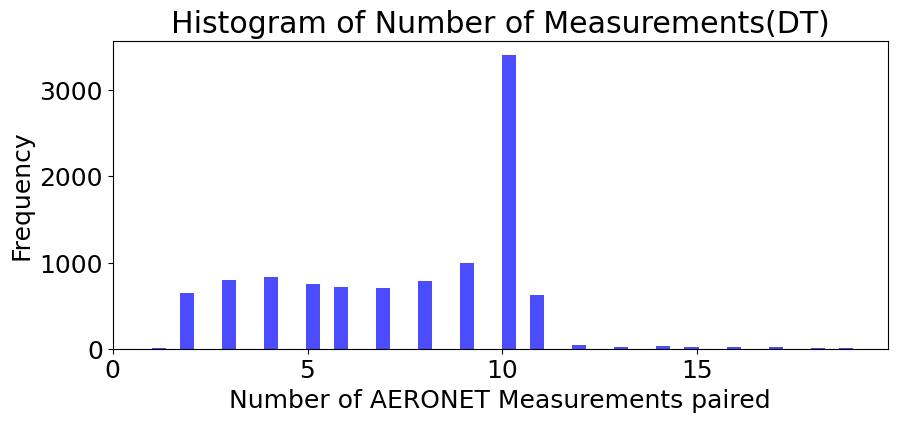

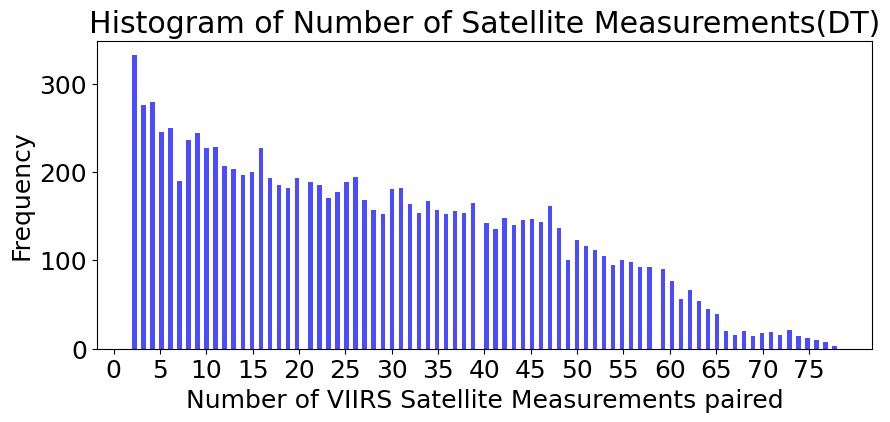

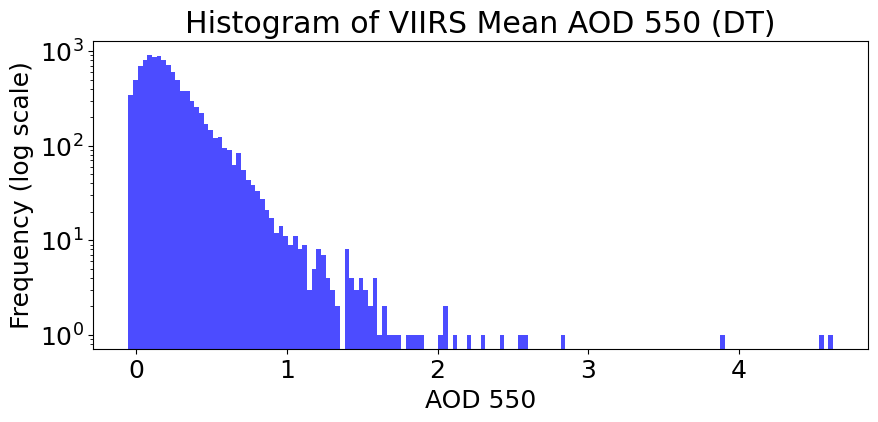

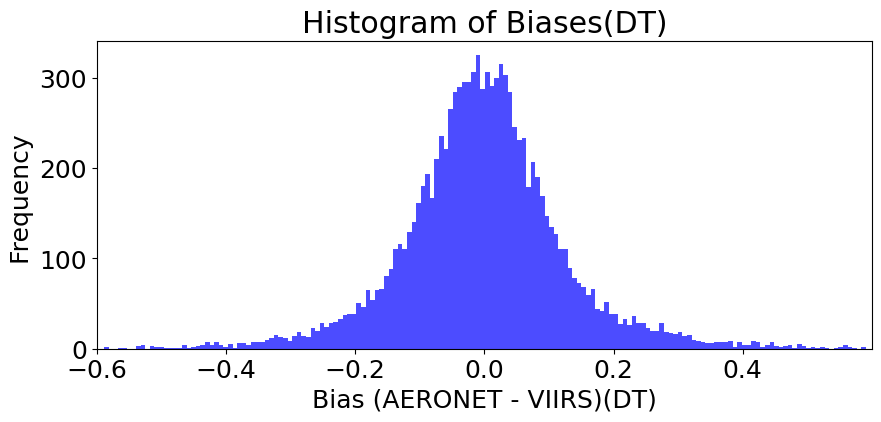

In [32]:
# plot the histogram of the number of measurements
plt.figure(figsize=(10, 4))
#increase the font size of all plots to 18
plt.rcParams.update({'font.size': 18})
plt.hist(matched_up_df['nMeas'], bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Number of Measurements({})'.format(stat_ret))
plt.xlabel('Number of AERONET Measurements paired')
plt.ylabel('Frequency')
# plt.grid()
# xticks at even intervals to max
plt.xticks(np.arange(0, matched_up_df['nMeas'].max()+1, 5))
plt.savefig(plots_dir+name_tag+stat_ret+'_histogram_nMeas.png', dpi=300)
plt.show()

# plot the histogram of the number of sat measurements
plt.figure(figsize=(10, 4))
plt.hist(matched_up_df['nPixs'], bins=156, color='blue', alpha=0.7)
plt.title('Histogram of Number of Satellite Measurements({})'.format(stat_ret))
plt.xlabel('Number of VIIRS Satellite Measurements paired')
plt.ylabel('Frequency')
# plt.grid()
# xticks at even intervals to max
plt.xticks(np.arange(0, matched_up_df['nPixs'].max()+1, 5))
plt.savefig(plots_dir+name_tag+stat_ret+'_histogram_nSatMeas.png', dpi=300)
plt.show()

#plot the histogram of AOD 550
plt.figure(figsize=(10, 4))
plt.hist(matched_up_df['satMean550'], bins=150, color='blue', alpha=0.7)
plt.title('Histogram of VIIRS Mean AOD 550 ({})'.format(stat_ret))
plt.xlabel('AOD 550')
plt.ylabel('Frequency (log scale)')
plt.yscale('log')
# plt.grid()
# xticks at even intervals to max
# plt.xticks(np.arange(-0.6, 0.6, 0.2))
# plt.xlim(-0.6, 0.6)
plt.savefig(plots_dir+name_tag+stat_ret+'_histogram_satMean550.png', dpi=300)
plt.show()  

#plot the histogram of biases
plt.figure(figsize=(10, 4))
plt.hist(matched_up_df['bias'], bins=400, color='blue', alpha=0.7)
plt.title('Histogram of Biases({})'.format(stat_ret))
plt.xlabel('Bias (AERONET - VIIRS)({})'.format(stat_ret))
plt.ylabel('Frequency ')
# plt.grid()
# xticks at even intervals to max
plt.xticks(np.arange(-0.6, 0.6, 0.2))
plt.xlim(-0.6, 0.6)
plt.savefig(plots_dir+name_tag+stat_ret+'_histogram_bias.png', dpi=300)
plt.show()  

regression
Iteration 1: 88.35% of points within bounds.
Optimization converged after 1 iterations.


(0.8668349458456962, 0.0326696751740835, None, None)

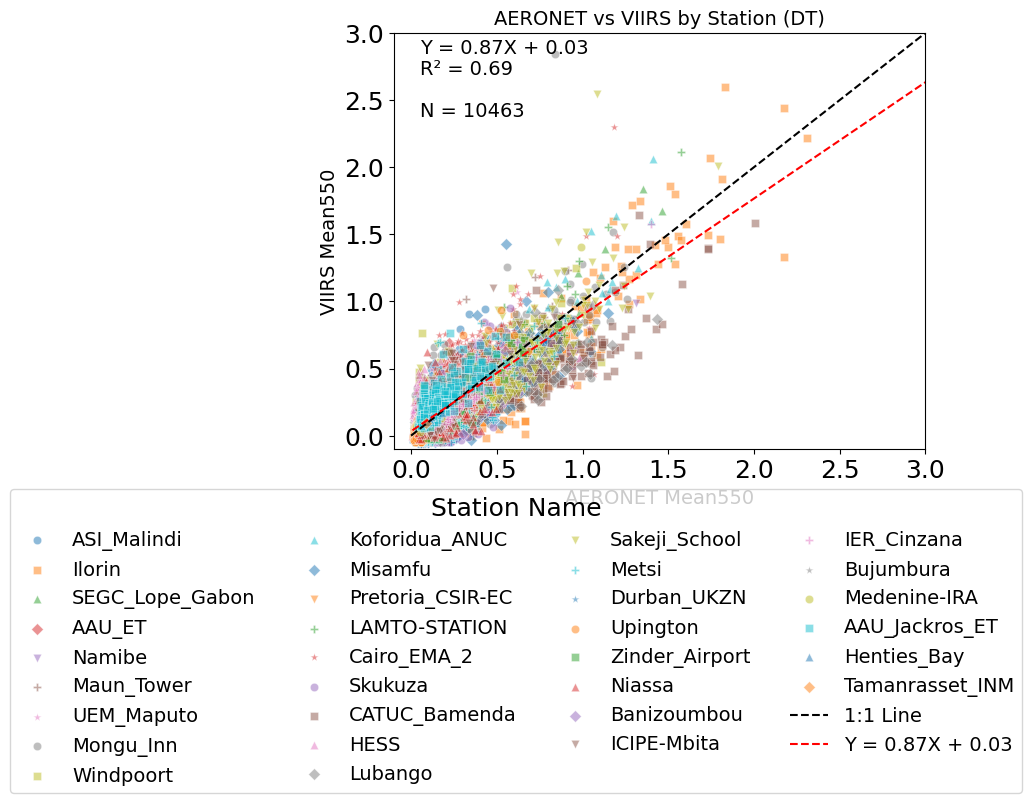

In [33]:
#make scatter plots of the aerMean550 satMean550 color by staName

plot_relationship(
    df=matched_up_df,
    x_col='aerMean550',
    y_col='satMean550',
    hue_col='staName',
    title='AERONET vs VIIRS by Station ({})'.format(stat_ret),
    xlabel='AERONET Mean550',
    ylabel='VIIRS Mean550',
    legend_title='Station Name',
    legend_loc='lower right',
    legend_bbox_to_anchor = (1.2, -0.85),
    legend_ncols=4,
    palette='viridis',
    save_path=os.path.join(plots_dir, '{}_aeronet_vs_viirs_bysation{}.png'.format(stat_ret,name_tag)),
    regression=True,
    use_palette_and_marker=True,  # Enable palette and markers
    xlim =(-0.1, 3),
    ylim =(-0.1, 3),
    figsize =(9,14),
    fontsize=14,
    alpha=0.5
)


/tmp/ipykernel_39039/600449929.py:54: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
/tmp/ipykernel_39039/600449929.py:54: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


regression
Iteration 1: 84.44% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 86.53% of points within bounds.
Optimization converged after 1 iterations.


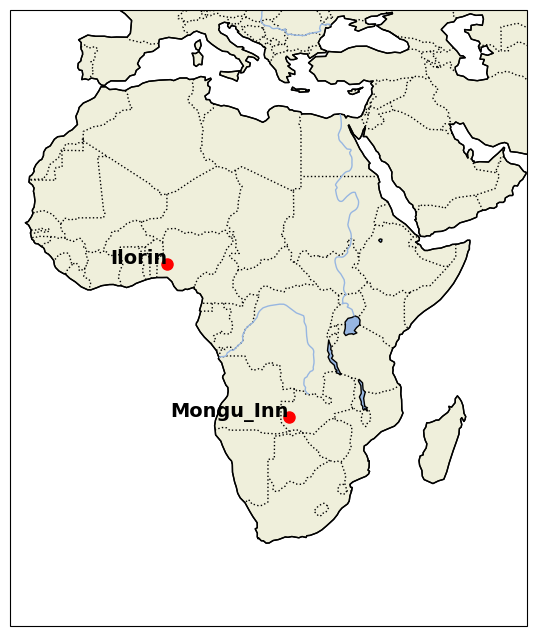

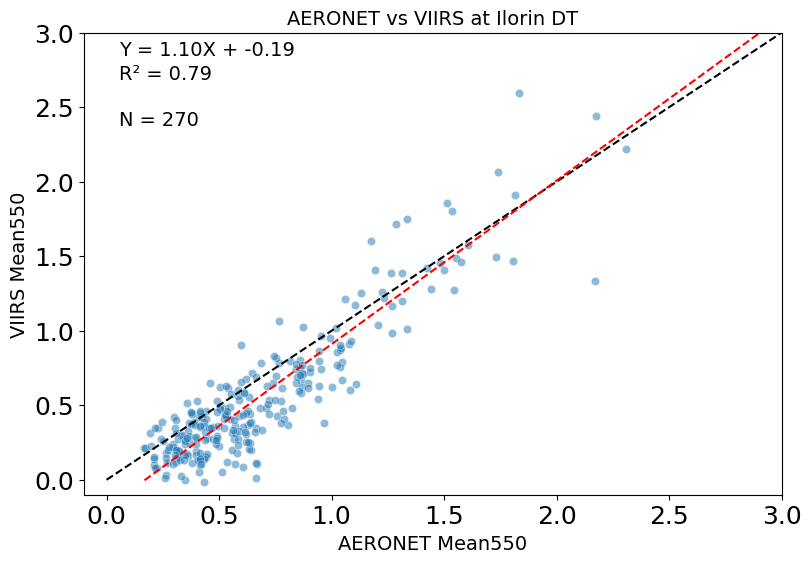

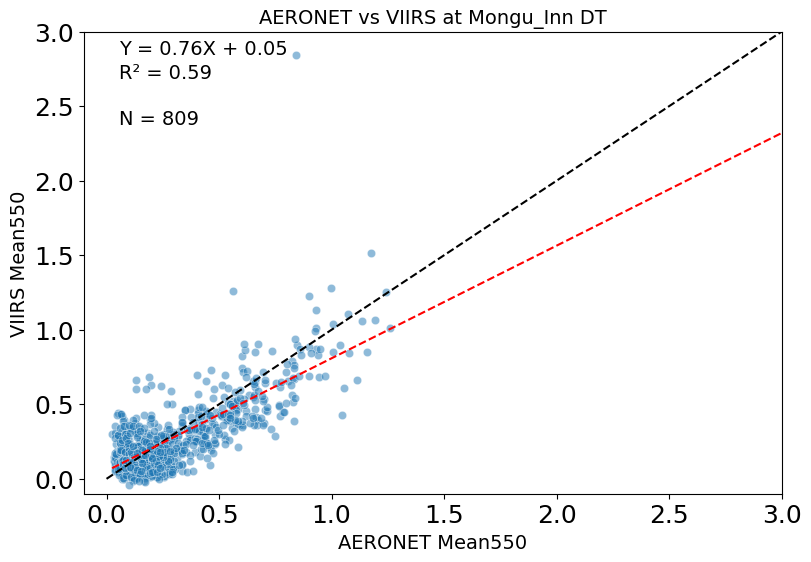

In [34]:
#select the data for the IIorin station and plot the scatter plot


stations=['Ilorin','Mongu_Inn']

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-20, 60, -40, 40])  # Set the extent to cover Africa

# Add features to the map
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.LAKES, edgecolor='black')
ax.add_feature(cfeature.RIVERS)



for station in stations:
    station_df=matched_up_df[matched_up_df['staName']==station]

    plot_relationship(
        df=station_df,
        x_col='aerMean550',
        y_col='satMean550',
        title='AERONET vs VIIRS at {} {}'.format(station, stat_ret),
        xlabel='AERONET Mean550',
        ylabel='VIIRS Mean550',
        legend_title='Station Name',
        legend_loc='lower right',
        legend_bbox_to_anchor = (1.2, -0.85),
        legend_ncols=4,
        palette='viridis',
        #save_path=os.path.join(plots_dir, 'aeronet_vs_viirs_{}.png'.format(station)),
        regression=True,
        xlim =(-0.1, 3),
        ylim =(-0.1, 3),
        figsize =(9,6),
        fontsize=14,
        alpha=0.5
    )

    #get the first data of eah df station_df[0]['lon'], station_df[0]['lat'] on a map
    ax.plot(
        station_df['staLon'].iloc[0], station_df['staLat'].iloc[0], 
        marker='o', color='red', markersize=8, 
        transform=ccrs.PlateCarree(), 
        label=station
    )
    #and add a text with the station name
    ax.text(
        station_df['staLon'].iloc[0], station_df['staLat'].iloc[0], 
        station, fontsize=14, fontweight='bold', ha='right', transform=ccrs.PlateCarree()
    )




#plot the scatter plot of the aerMean550 and satMean550 for all the stations

regression
Iteration 1: 88.35% of points within bounds.
Optimization converged after 1 iterations.


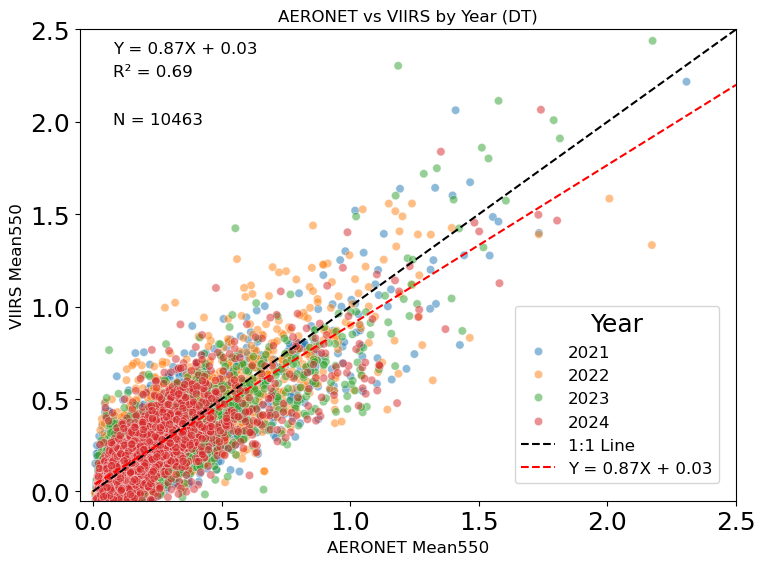

In [36]:
#make scatter plots of the aerMean550 satMean550 color by year

slope, intercept, slope_std, intercept_std=plot_relationship(
    df=matched_up_df,
    x_col='aerMean550',
    y_col='satMean550',
    hue_col='year',
    title='AERONET vs VIIRS by Year ({})'.format(stat_ret),
    xlabel='AERONET Mean550',
    ylabel='VIIRS Mean550',
    legend_title='Year',
    legend_loc='lower left',
    legend_bbox_to_anchor=(0.65, 0.02),
    legend_ncols=1,
    save_path=os.path.join(plots_dir, '{}_aeronet_vs_viirs_byyear{}.png'.format(stat_ret,name_tag)),
    regression=True,
    xlim=(-0.05, 2.5),
    ylim=(-0.05, 2.5),
    figsize=(8, 6),
    fontsize=12,
    alpha=0.5
)



regression
Iteration 1: 85.89% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 88.05% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 87.21% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 86.25% of points within bounds.
Optimization converged after 1 iterations.


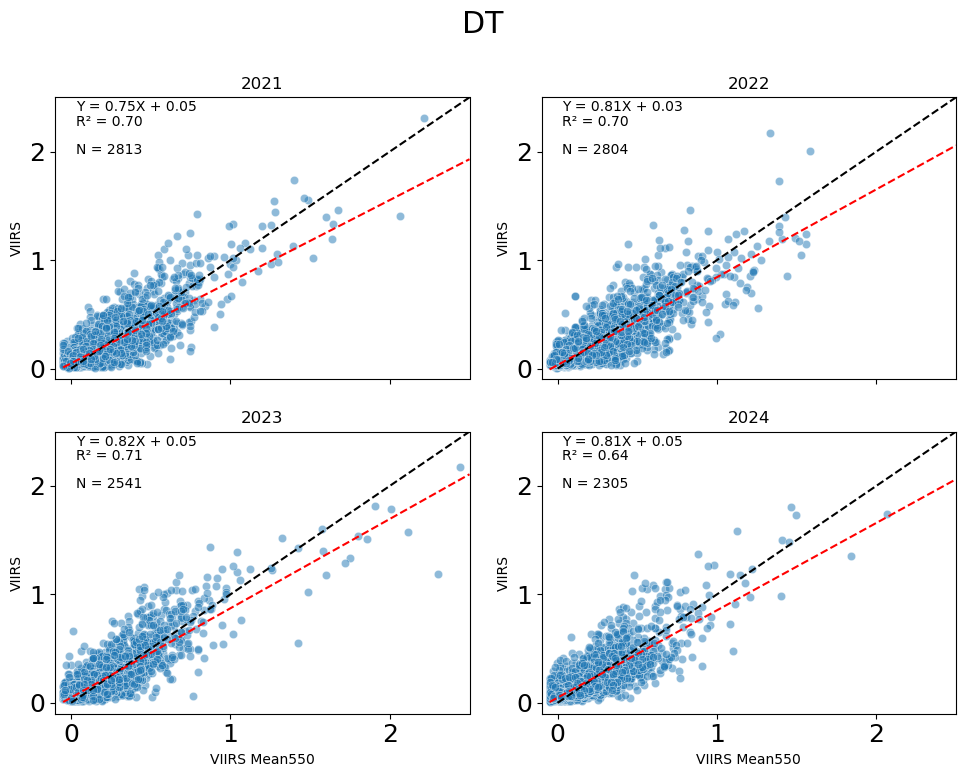

In [37]:
# Ensure the 'year' column exists in the DataFrame


unique_years = matched_up_df['year'].unique()
unique_years.sort()

# Create subplots for each year
fig, axes = plt.subplots(nrows=int(len(unique_years)/2), ncols=2, figsize=(10, 2 * len(unique_years)), sharex=True)
axes=axes.ravel()

# Loop through each year and call the plot_relationship function
for i, year in enumerate(unique_years):
    ax = axes[i] if len(unique_years) > 1 else axes  # Handle single subplot case
    year_data = matched_up_df[matched_up_df['year'] == year]  # Filter data for the current year
    
    # Call the plot_relationship function for the current year
    plot_relationship(
        ax=ax,
        df=year_data,
        x_col='satMean550',
        y_col='aerMean550',
        title=f' {year}',
        xlabel='VIIRS Mean550',
        ylabel='VIIRS',
        legend_title=None,
        legend_loc='upper right',
        legend_bbox_to_anchor=None,
        legend_ncols=1,
        regression=True,
        xlim=(-0.1, 2.5),
        ylim=(-0.1, 2.5),
        alpha=0.5,
        figsize=(6, 6),
        fontsize=10,
        palette=None  # Use default random discrete colors
    )
    ax.set_title(f'{year}', fontsize=12)
# Adjust layout and save the figure
plt.suptitle(stat_ret)
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, '{}_aeronet_vs_viirs_seperate_years{}.png'.format(stat_ret,name_tag)), dpi=300)
plt.show()

regression
plot_error_bar
Percentage of Points Within Bounds: 87.44%


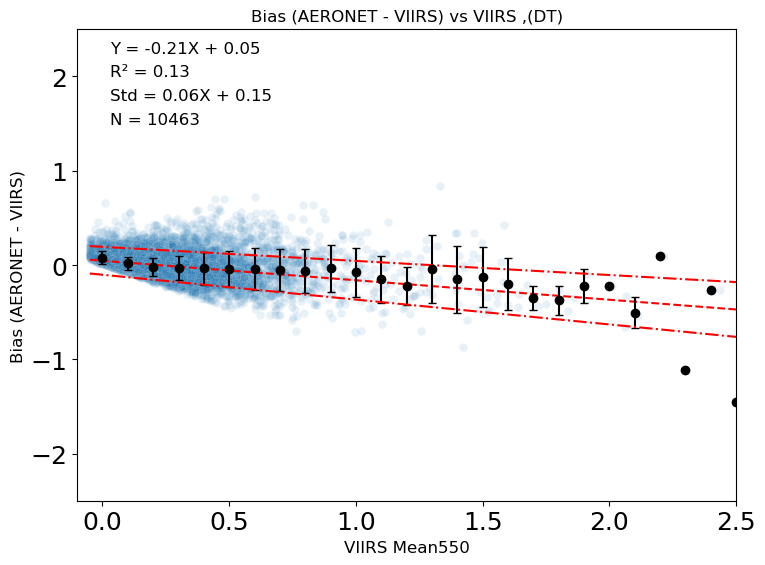

In [38]:
# Calculate the bias (AERONET - VIIRS)

slope, intercept, slope_std, intercept_std=plot_relationship(
    df=matched_up_df,
    x_col='satMean550',
    y_col='bias',
    title='Bias (AERONET - VIIRS) vs VIIRS ,({})'.format(stat_ret),
    xlabel='VIIRS Mean550',
    ylabel='Bias (AERONET - VIIRS)',
    plot_error_bar=True,
    one_one_line=False,
    legend_title=None,
    legend_loc='upper right',
    save_path=os.path.join(plots_dir, '{}_error_aeronet_vs_viirs{}.png'.format(stat_ret,name_tag)),
    regression=True,
    xlim=(-0.1, 2.5),
    ylim=(-2.5, 2.5),
    alpha=0.1,
    figsize=(8, 6),
    fontsize=12,
    palette=None
)

#check what percentage of the data is within the bounds
# Calculate the upper and lower bounds
# x = matched_up_df['satMean550'].values
# y = matched_up_df['bias'].values

# upper_bound = (slope_std * x + intercept_std) + (slope* x + intercept)
# lower_bound = -(slope_std * x + intercept_std) + (slope * x + intercept)

# # Check how many points lie within the bounds
# within_bounds = (y >= lower_bound) & (y <= upper_bound)
# percentage_within_bounds = np.sum(within_bounds) / len(y) * 100

# # Print the result
# print(f"Percentage of Points Within Bounds: {percentage_within_bounds:.2f}%")


In [75]:
# df=matched_up_df
# x_col='satMean550'
# y_col='bias'
 


# # slope, intercept = np.polyfit(df[x_col], df[y_col], 1) 
# # Bin the data into intervals of 0.1 along the x-axis
# bins = np.arange(df[x_col].min(), df[x_col].max() + 0.1, 0.1)
# bin_centers = (bins[:-1] + bins[1:]) / 2
# means = []
# stds = []

# for i in range(len(bins) - 1):
#     bin_data = df[(df[x_col] >= bins[i]) & (df[x_col] < bins[i + 1])]
#     means.append(bin_data[y_col].mean())
#     stds.append(bin_data[y_col].std())
# means = np.array(means)

# bin_centers = bin_centers[~np.isnan(means)]
# means = means[~np.isnan(means)]
# slope, intercept = np.polyfit(bin_centers, means, 1) 
# # Plot error bars
# # ax.errorbar(bin_centers, means, yerr=stds, fmt='o', color='black', capsize=3, label='STD')
# # also estiamte the equation of how std values change with x (AOD)
# stds = np.array(stds)
# bin_centers = (bins[:-1] + bins[1:]) / 2
# bin_centers = bin_centers[~np.isnan(stds)]
# stds = stds[~np.isnan(stds)]
# slope_std, intercept_std = np.polyfit(bin_centers, stds, 1)
# # slope_std, intercept_std ,temp =optimize_regression_fit_np(bin_centers, stds)
# #add a text for this equation





regression
plot_error_bar
Percentage of Points Within Bounds: 82.87%
regression
plot_error_bar
Percentage of Points Within Bounds: 78.03%
regression
plot_error_bar
Percentage of Points Within Bounds: 85.28%
regression
plot_error_bar
Percentage of Points Within Bounds: 83.82%


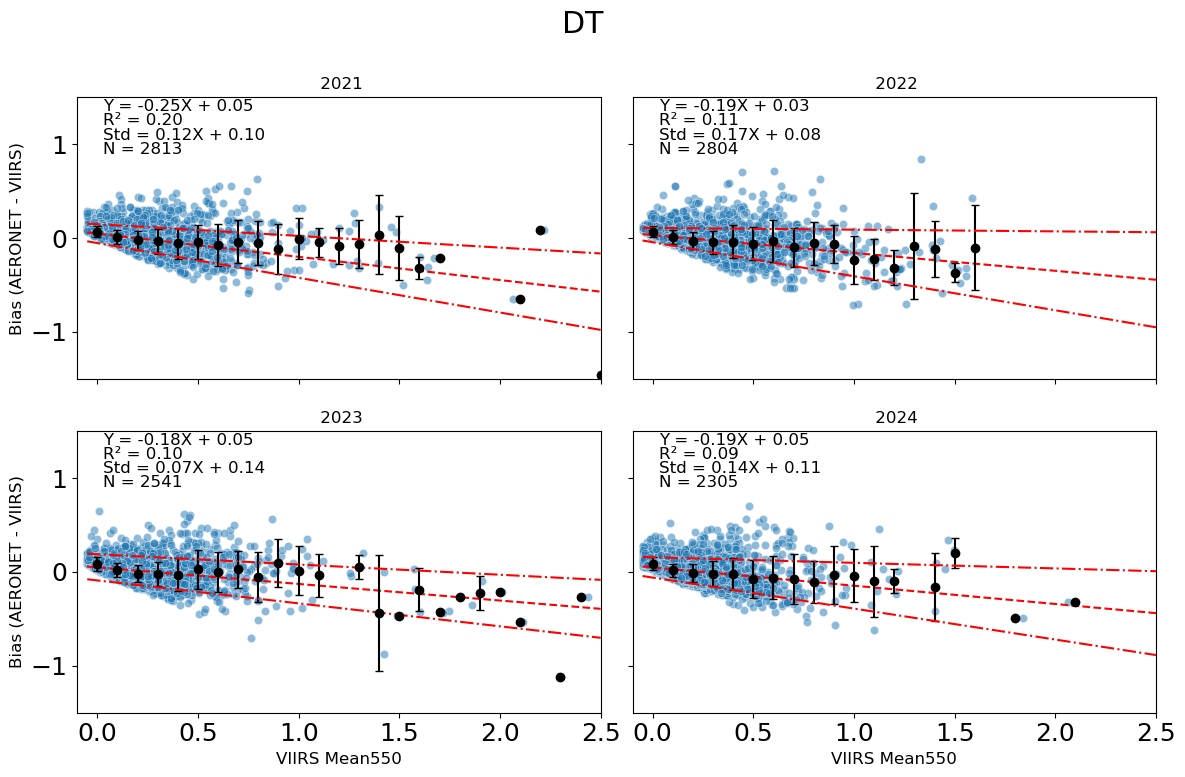

In [39]:
# Ensure the 'year' column exists in the DataFrame
unique_years = matched_up_df['year'].unique()
unique_years.sort()

# Create subplots for each year
fig, axes = plt.subplots(nrows=int(np.ceil(len(unique_years) / 2)), ncols=2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.ravel()

# Loop through each year and plot the bias
for i, year in enumerate(unique_years):
    ax = axes[i]
    year_data = matched_up_df[matched_up_df['year'] == year]
    
    #call the plot_relationship function for the current year
    plot_relationship(
        ax=ax,
        df=year_data,
        x_col='satMean550',
        y_col='bias',
        title=f' {year}',
        xlabel='VIIRS Mean550',
        ylabel='Bias (AERONET - VIIRS)',
        one_one_line=False,
        plot_error_bar=True,
        legend_title=None,
        legend_loc='upper right',
        regression=True,
        xlim=(-0.1, 2.5),
        ylim=(-1.5, 1.5),
        alpha=0.5,
        figsize=(6, 6),
        fontsize=12,
        palette=None
    )


# Hide unused subplots if any
plt.suptitle(stat_ret)
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)
save_path=os.path.join(plots_dir, '{}_aerror_aeronet_vs_viirs_seperate_years{}.png'.format(stat_ret,name_tag))
plt.savefig(save_path, dpi=300)
plt.tight_layout()
plt.show()

regression
Iteration 1: 88.35% of points within bounds.
Optimization converged after 1 iterations.


(0.8668349458456962, 0.0326696751740835, None, None)

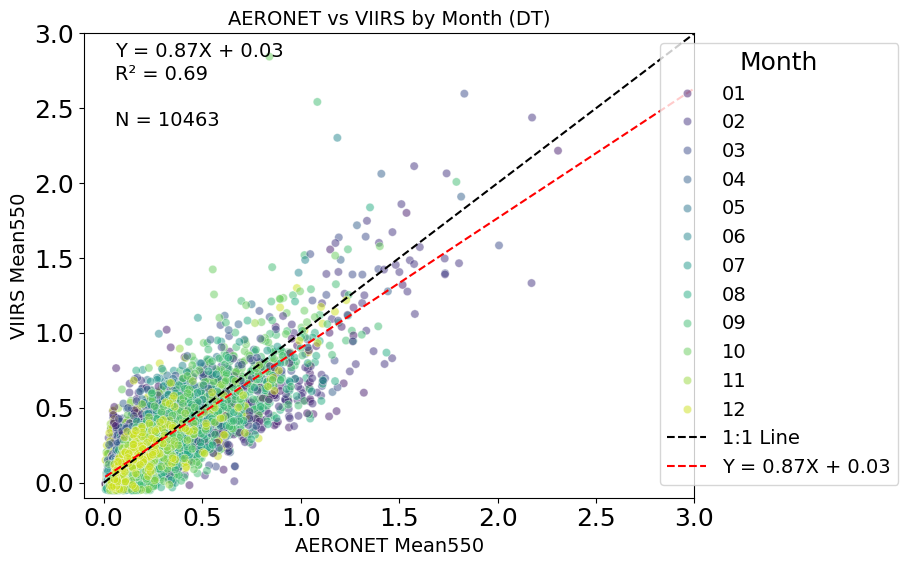

In [40]:
#make scatter plots of the aerMean550 satMean550 color by month
matched_up_df['month']=matched_up_df['date'].str[4:6]
plot_relationship(
    df=matched_up_df,
    x_col='aerMean550',
    y_col='satMean550',
    hue_col='month',
    title='AERONET vs VIIRS by Month ({})'.format(stat_ret),
    xlabel='AERONET Mean550',
    ylabel='VIIRS Mean550',
    legend_title='Month',
    legend_loc='upper right',
    legend_bbox_to_anchor=(1.35, 1),
    legend_ncols=1,
    save_path=os.path.join(plots_dir, '{}_aeronet_vs_viirs_bymonth{}.png'.format(stat_ret,name_tag)),
    regression=True,
    xlim=(-0.1, 3),
    ylim=(-0.1, 3),
    figsize=(10, 6),
    fontsize=14,
    alpha=0.5,
    palette='viridis'
)

regression
Iteration 1: 90.05% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 89.22% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 85.22% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 88.96% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 85.68% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 79.45% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 82.25% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 86.19% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 90.61% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 89.78% of points within bounds.
Optimization converged after 1 iterations.
regression

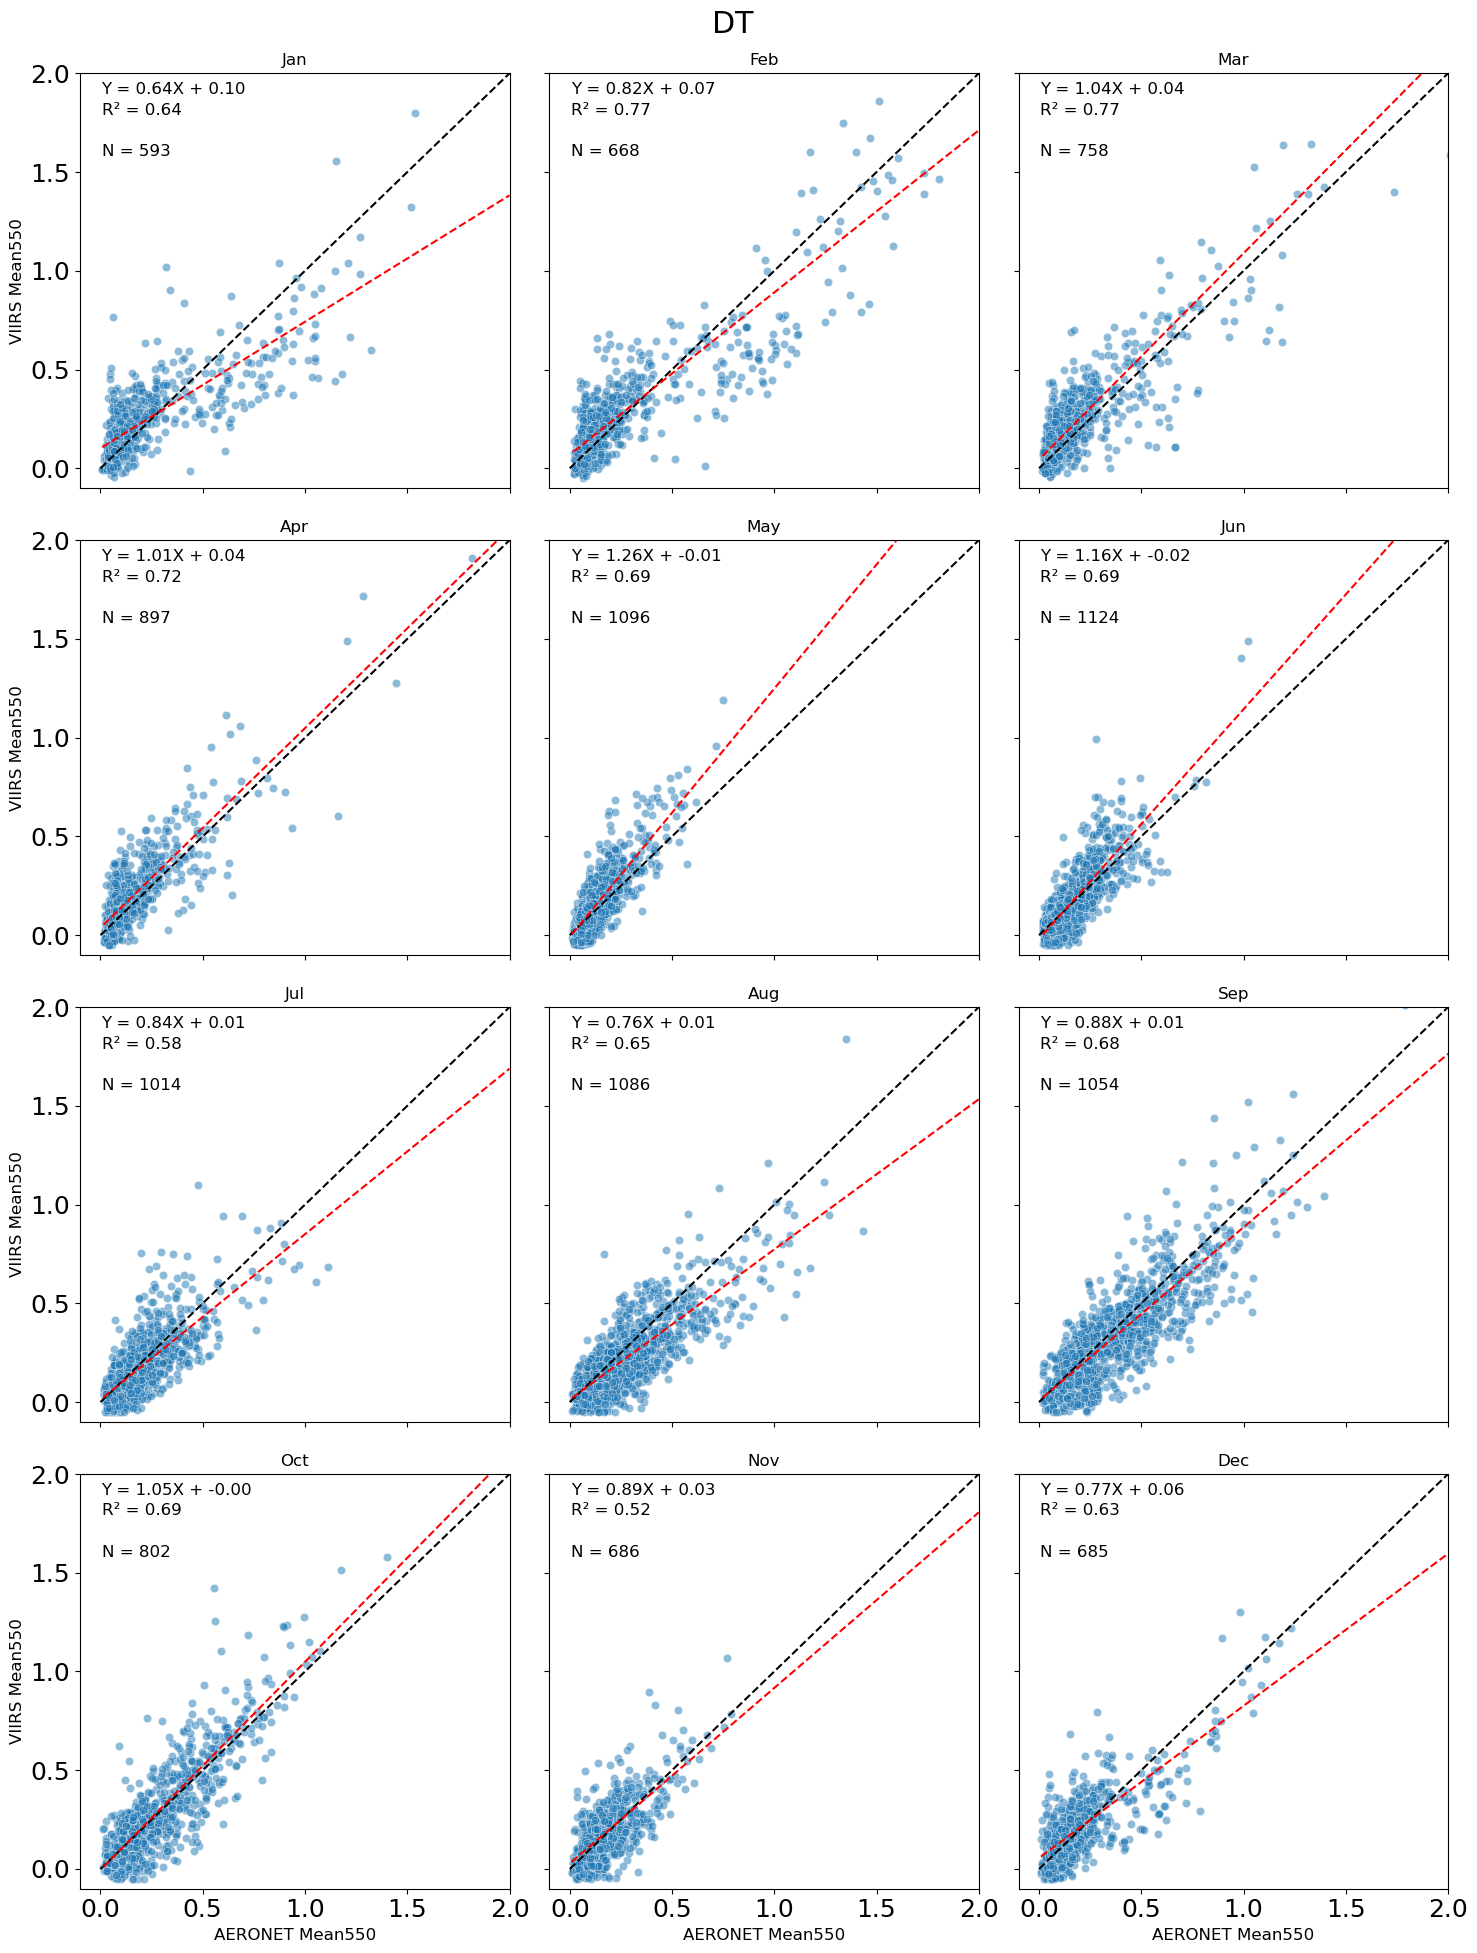

<Figure size 640x480 with 0 Axes>

In [41]:
import calendar

# Ensure the 'month' column exists in the DataFrame
unique_months = matched_up_df['month'].unique()
unique_months.sort()

# Create subplots for each month
fig, axes = plt.subplots(nrows=int(np.ceil(len(unique_months) / 3)), ncols=3, figsize=(15, 5 * int(np.ceil(len(unique_months) / 3))), sharex=True, sharey=True)
axes = axes.ravel()

# Loop through each month and plot the data
for i, month in enumerate(unique_months):
    ax = axes[i]
    month_data = matched_up_df[matched_up_df['month'] == month]
    month_name = calendar.month_abbr[int(month)]  # Convert month number to name
    
    # Call the plot_relationship function for the current month
    plot_relationship(
        ax=ax,
        df=month_data,
        x_col='aerMean550',
        y_col='satMean550',
        title=f'{month_name}',
        xlabel='AERONET Mean550',
        ylabel='VIIRS Mean550',
        legend_title=None,
        legend_loc='upper right',
        regression=True,
        xlim=(-0.1, 2),
        ylim=(-0.1, 2),
        alpha=0.5,
        figsize=(6, 6),
        fontsize=12,
        palette=None
    )

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle(stat_ret)
plt.tight_layout()
plt.show()

save_path=os.path.join(plots_dir, '{}_aeronet_vs_viirs_seperate_months{}.png'.format(stat_ret,name_tag))
plt.savefig(save_path, dpi=300)


regression
plot_error_bar
Percentage of Points Within Bounds: 75.04%
regression
plot_error_bar
Percentage of Points Within Bounds: 80.39%
regression
plot_error_bar
Percentage of Points Within Bounds: 81.79%
regression
plot_error_bar
Percentage of Points Within Bounds: 86.62%
regression
plot_error_bar
Percentage of Points Within Bounds: 82.03%
regression
plot_error_bar
Percentage of Points Within Bounds: 68.59%
regression
plot_error_bar
Percentage of Points Within Bounds: 70.02%
regression
plot_error_bar
Percentage of Points Within Bounds: 69.06%
regression
plot_error_bar
Percentage of Points Within Bounds: 70.40%
regression
plot_error_bar
Percentage of Points Within Bounds: 66.21%
regression
plot_error_bar
Percentage of Points Within Bounds: 73.47%
regression
plot_error_bar
Percentage of Points Within Bounds: 81.46%


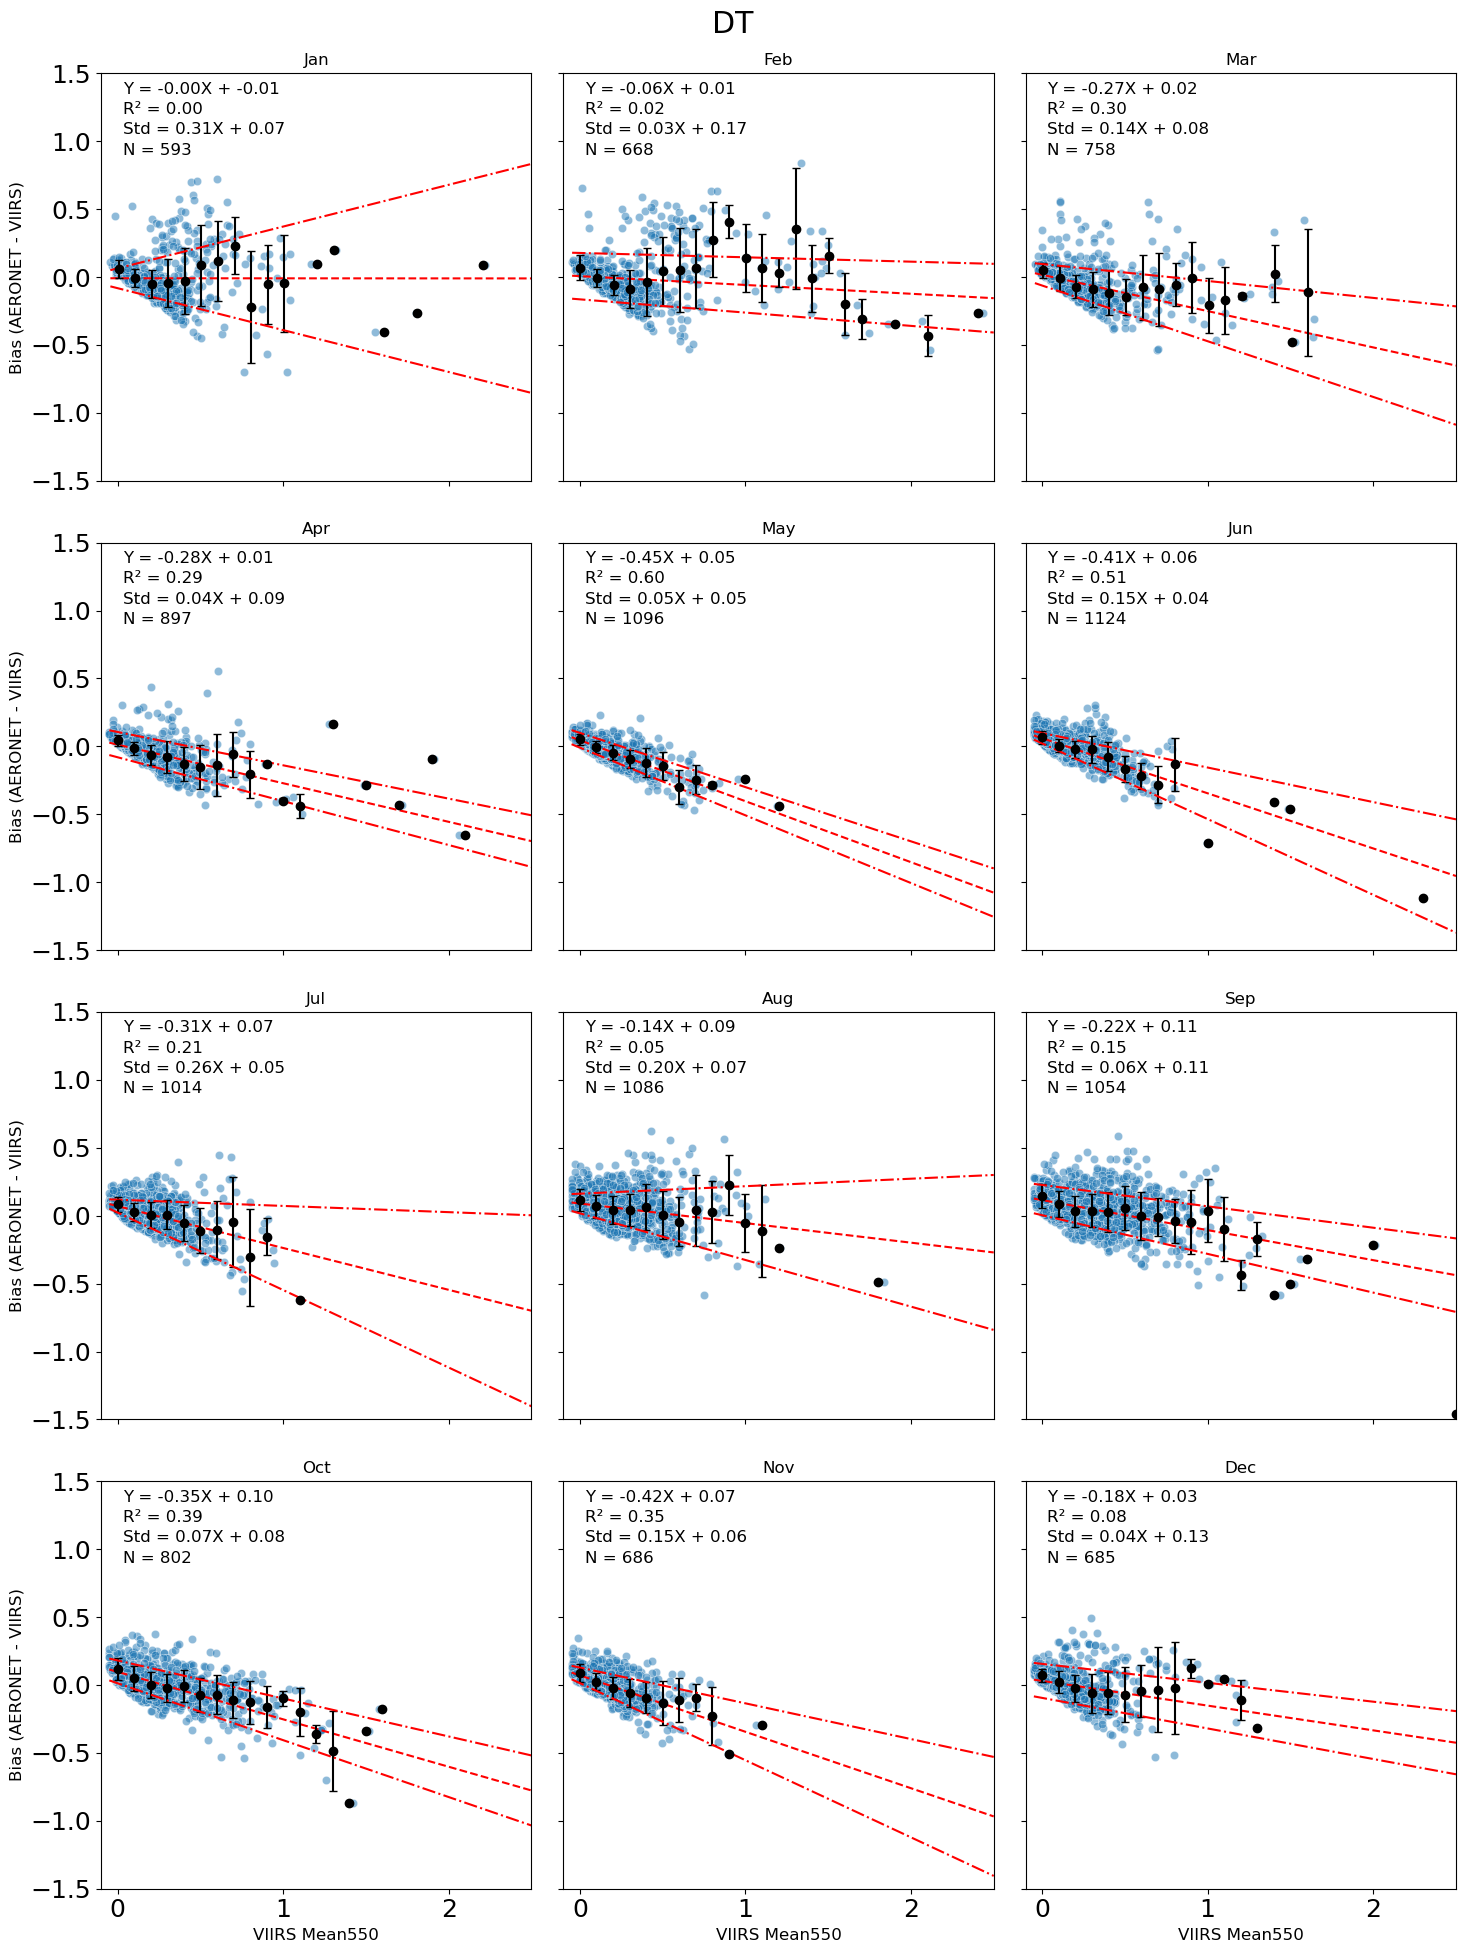

<Figure size 640x480 with 0 Axes>

In [42]:
# Ensure the 'month' column exists in the DataFrame
unique_months = matched_up_df['month'].unique()
unique_months.sort()

# Create subplots for each month
fig, axes = plt.subplots(nrows=int(np.ceil(len(unique_months) / 3)), ncols=3, figsize=(15, 5 * int(np.ceil(len(unique_months) / 3))), sharex=True, sharey=True)
axes = axes.ravel()

# Loop through each month and plot the bias
for i, month in enumerate(unique_months):
    ax = axes[i]
    month_data = matched_up_df[matched_up_df['month'] == month]
    month_name = calendar.month_abbr[int(month)]  # Convert month number to name
    
    # Call the plot_relationship function for the current month
    plot_relationship(
        ax=ax,
        df=month_data,
        x_col='satMean550',
        y_col='bias',
        title=f'{month_name}',
        xlabel='VIIRS Mean550',
        ylabel='Bias (AERONET - VIIRS)',
        one_one_line=False,
        plot_error_bar=True,
        legend_title=None,
        legend_loc='upper right',
        regression=True,
        xlim=(-0.1, 2.5),
        ylim=(-1.5, 1.5),
        alpha=0.5,
        figsize=(6, 6),
        fontsize=12,
        palette=None
    )

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)
plt.suptitle(stat_ret)
plt.tight_layout()
plt.show()

save_path=os.path.join(plots_dir, '{}_error_aeronet_vs_viirs_seperate_months{}.png'.format(stat_ret,name_tag))
plt.savefig(save_path, dpi=300)



In [ ]:


# Example usage
slope_mean, intercept_mean, slope_std, intercept_std, percentage_within_bounds = optimize_regression_fit_np_error_2aod(
    df=matched_up_df,
    x_col='satMean550',
    y_col='bias'
)

print(f"Optimized Slope (Mean): {slope_mean}")
print(f"Optimized Intercept (Mean): {intercept_mean}")
print(f"Optimized Slope (Std): {slope_std}")
print(f"Optimized Intercept (Std): {intercept_std}")
print(f"Percentage of Points Within Bounds: {percentage_within_bounds:.2%}")
slope_mean, intercept_mean, slope_std, intercept_std,